# Non i.i.d. data

In machine learning, it is quite common to assume that the data are i.i.d,
meaning that the generative process does not have any memory of past samples
to generate new samples.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">i.i.d is the acronym of "independent and identically distributed"
(as in "independent and identically distributed random variables").</p>
</div>

This assumption is usually violated when dealing with time series. A sample
depends on past information.

We will take an example to highlight such issues with non-i.i.d. data in the
previous cross-validation strategies presented. We are going to load
financial quotations from some energy companies.

In [1]:
import pandas as pd

symbols = {"TOT": "Total", "XOM": "Exxon", "CVX": "Chevron",
           "COP": "ConocoPhillips", "VLO": "Valero Energy"}
template_name = ("../datasets/financial-data/{}.csv")

quotes = {}
for symbol in symbols:
    data = pd.read_csv(
        template_name.format(symbol), index_col=0, parse_dates=True
    )
    quotes[symbols[symbol]] = data["open"]
quotes = pd.DataFrame(quotes)

We can start by plotting the different financial quotations.

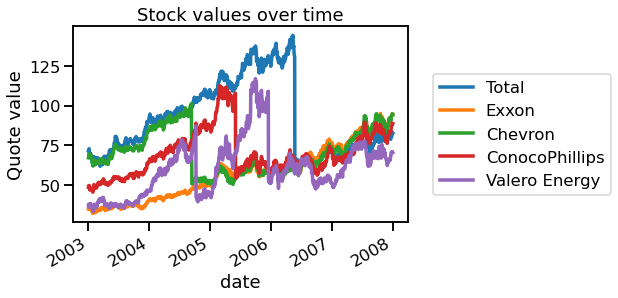

In [2]:
import matplotlib.pyplot as plt

quotes.plot()
plt.ylabel("Quote value")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Stock values over time")

We will repeat the experiment asked during the exercise. Instead of using
random data, we will use real quotations this time. While it was obvious that
a predictive model could not work in practice on random data, this is the
same on these real data. So here, we want to predict the quotation of Chevron
using all other energy companies' quotes.

To make explanatory plots, we will use a single split in addition to the
cross-validation that you used in the introductory exercise.

In [3]:
from sklearn.model_selection import train_test_split

data, target = quotes.drop(columns=["Chevron"]), quotes["Chevron"]
data_train, data_test, target_train, target_test = train_test_split(
    data, target, shuffle=True, random_state=0)

We will use a decision tree regressor that we expect to overfit and thus not
generalize to unseen data. We will use a `ShuffleSplit` cross-validation to
check the generalization performance of our model.

Let's first define our model

In [4]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

And now the cross-validation strategy.

In [5]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(random_state=0)

Finally, we perform the evaluation.

In [6]:
from sklearn.model_selection import cross_val_score

test_score = cross_val_score(regressor, data_train, target_train, cv=cv,
                             n_jobs=2)
print(f"The mean R2 is: "
      f"{test_score.mean():.2f} +/- {test_score.std():.2f}")

The mean R2 is: 0.95 +/- 0.07


Surprisingly, we get outstanding generalization performance. We will investigate
and find the reason for such good results with a model that is expected to
fail. We previously mentioned that `ShuffleSplit` is an iterative
cross-validation scheme that shuffles data and split. We will simplify this
procedure with a single split and plot the prediction. We can use
`train_test_split` for this purpose.

In [7]:
regressor.fit(data_train, target_train)
target_predicted = regressor.predict(data_test)
# Affect the index of `target_predicted` to ease the plotting
target_predicted = pd.Series(target_predicted, index=target_test.index)

Let's check the generalization performance of our model on this split.

In [8]:
from sklearn.metrics import r2_score

test_score = r2_score(target_test, target_predicted)
print(f"The R2 on this single split is: {test_score:.2f}")

The R2 on this single split is: 0.83


Similarly, we obtain good results in terms of $R^2$.
We will plot the training, testing and prediction samples.

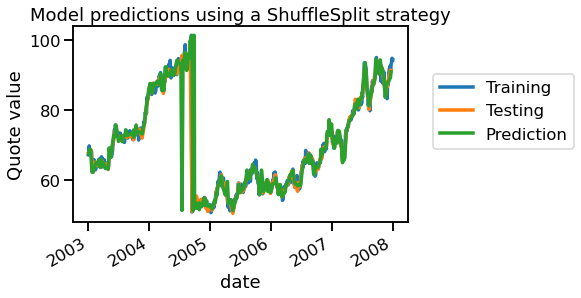

In [9]:
target_train.plot(label="Training")
target_test.plot(label="Testing")
target_predicted.plot(label="Prediction")

plt.ylabel("Quote value")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Model predictions using a ShuffleSplit strategy")

So in this context, it seems that the model predictions are following the
testing. But we can also see that the testing samples are next to some
training sample. And with these time-series, we see a relationship between a
sample at the time `t` and a sample at `t+1`. In this case, we are violating
the i.i.d. assumption. The insight to get is the following: a model can
output of its training set at the time `t` for a testing sample at the time
`t+1`. This prediction would be close to the true value even if our model
did not learn anything, but just memorized the training dataset.

An easy way to verify this hypothesis is to not shuffle the data when doing
the split. In this case, we will use the first 75% of the data to train and
the remaining data to test.

In [10]:
data_train, data_test, target_train, target_test = train_test_split(
    data, target, shuffle=False, random_state=0,
)
regressor.fit(data_train, target_train)
target_predicted = regressor.predict(data_test)
target_predicted = pd.Series(target_predicted, index=target_test.index)

In [11]:
test_score = r2_score(target_test, target_predicted)
print(f"The R2 on this single split is: {test_score:.2f}")

The R2 on this single split is: -2.19


In this case, we see that our model is not magical anymore. Indeed, it
performs worse than just predicting the mean of the target. We can visually
check what we are predicting.

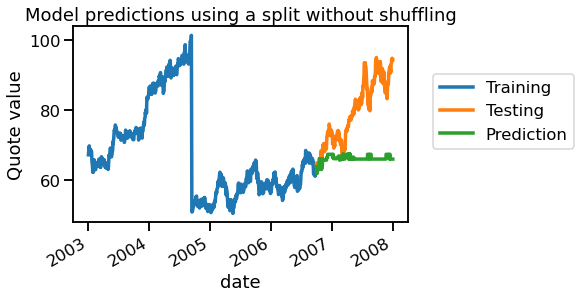

In [12]:
target_train.plot(label="Training")
target_test.plot(label="Testing")
target_predicted.plot(label="Prediction")

plt.ylabel("Quote value")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Model predictions using a split without shuffling")

We see that our model cannot predict anything because it doesn't have samples
around the testing sample. Let's check how we could have made a proper
cross-validation scheme to get a reasonable generalization performance estimate.

One solution would be to group the samples into time blocks, e.g. by quarter,
and predict each group's information by using information from the other
groups. We can use the `LeaveOneGroupOut` cross-validation for this purpose.

In [13]:
from sklearn.model_selection import LeaveOneGroupOut

groups = quotes.index.to_period("Q")
cv = LeaveOneGroupOut()
test_score = cross_val_score(regressor, data, target,
                             cv=cv, groups=groups, n_jobs=2)
print(f"The mean R2 is: "
      f"{test_score.mean():.2f} +/- {test_score.std():.2f}")

The mean R2 is: -1.03 +/- 1.81


In this case, we see that we cannot make good predictions, which is less
surprising than our original results.

Another thing to consider is the actual application of our solution. If our
model is aimed at forecasting (i.e., predicting future data from past data),
we should not use training data that are ulterior to the testing data. In
this case, we can use the `TimeSeriesSplit` cross-validation to enforce this
behaviour.

In [1]:
from sklearn.model_selection import TimeSeriesSplit

cv = TimeSeriesSplit(n_splits=groups.nunique())
test_score = cross_val_score(regressor, data, target,
                             cv=cv, groups=groups, n_jobs=2)
print(f"The mean R2 is: "
      f"{test_score.mean():.2f} +/- {test_score.std():.2f}")

SyntaxError: invalid syntax (2682020347.py, line 1)

In conclusion, it is really important to not use an out of the shelves
cross-validation strategy which do not respect some assumptions such as
having i.i.d data. It might lead to absurd results which could make think
that a predictive model might work.